In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as osp
import pprint

from polars import Int8, Float32, Float64, Boolean

from dataset.generation.generator import (StructuralDatasetGenerator,
                                          PlanarTrussGenerator,
                                          LinearCantileverTrussGenerator,
                                          LinearTwoBarTruss)

from dataset.generation.analysis import LinearAnalysis

np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(formatter={'float_kind':
                                   lambda x:
                                   f"{x:.2e}".rjust(11, ' ') if abs(x) > 1e-4
                                   else "0.".rjust(11, ' ') if x == 0 else "~0.".rjust(11, ' ')})

In [2]:
class Plotter:
    @staticmethod
    def plot(ax=None,
             support=True,
             node_label=True, elem_label=True, dimension=True,
             line_color='black', line_style='--', line_width=1,
             deformed=True, deformed_line_color='red', deformed_line_style='-', deformed_line_width=1,
             scale_factor=50):

        # Create axis if not given    
        if ax is None:
            _, ax = plt.subplots()
            ax.set_aspect('equal', 'box')

        # Get undisplaced nodes coordinates
        node_coords = {node_tag: osp.nodeCoord(node_tag) for node_tag in osp.getNodeTags()}

        # Get displaced node coordinates
        disp_coords = {node_tag:
            [
                osp.nodeCoord(node_tag)[0] + osp.nodeDisp(node_tag, 1) * scale_factor,
                osp.nodeCoord(node_tag)[1] + osp.nodeDisp(node_tag, 2) * scale_factor
            ]
            for node_tag in osp.getNodeTags()
        }

        # Get connectivity matrix
        connectivity = {elem_tag: osp.eleNodes(elem_tag) for elem_tag in osp.getEleTags()}

        # Plot underformed shape
        for tag, nodes in connectivity.items():
            x = [node_coords[node][0] for node in nodes]
            y = [node_coords[node][1] for node in nodes]
            ax.plot(x, y, linestyle=line_style, color=line_color, linewidth=line_width)

            if elem_label:
                Plotter._annotate_element(ax, x, y, tag, color=line_color)

        # Plot nodes
        r = np.max([*ax.get_xlim(), *ax.get_ylim()]) * 0.005
        for tag, node_coord in node_coords.items():
            if node_label:
                Plotter._annotate_node(ax, node_coord, tag, offset=r, color=line_color)
            Plotter._plot_node(ax, node_coord, r, color=line_color)

        # Plot deformed shape
        if deformed:
            for tag, nodes in connectivity.items():
                x = [disp_coords[node][0] for node in nodes]
                y = [disp_coords[node][1] for node in nodes]
                ax.plot(x, y, linestyle=deformed_line_style, color=deformed_line_color, linewidth=deformed_line_width)

            # Plot nodes
            for node_coord in disp_coords.values():
                Plotter._plot_node(ax, node_coord, r, color=deformed_line_color)

        return ax

    @staticmethod
    def _plot_node(ax, coordinates, r, color='black'):
        node = plt.Circle(coordinates, radius=r, color=color)
        ax.add_patch(node)

    @staticmethod
    def _annotate_node(ax, coordinates, tag, offset=0., color='black'):
        coordinates = [xi + offset for xi in coordinates]
        ax.annotate(tag, coordinates, color=color, fontweight="semibold")

    @staticmethod
    def _annotate_element(ax, x, y, tag, offset=0., color='black'):
        coordinates = [x[1] + .3 * (x[0] - x[1]), y[1] + .3 * (y[0] - y[1])]
        coordinates = [xi + offset for xi in coordinates]
        ax.annotate(tag, coordinates, color=color)

In [3]:
structure_df = LinearTwoBarTruss({
    'parameters': {
        'length': {
            'default': {'type': 'UNIFORM', 'parameters': (2., 10.)}
        },
        'supports': {
            '0-x': {'type': 'CONSTANT', 'parameters': (1,)},
            '0-y': {'type': 'CONSTANT', 'parameters': (1,)},
            '1-x': {'type': 'CONSTANT', 'parameters': (1,)},
            '1-y': {'type': 'CONSTANT', 'parameters': (1,)},
        },
        'loads': {
            '2-y': {'type': 'DISTRIBUTION', 'parameters': ('load',)},
        }
    },
    'distributions': {
        'load': {'type': 'CONSTANT', 'parameters': (-1000.e3,)},
    }
}
)

structure_df = LinearCanteliverTrussGenerator({
    'parameters': {
        'cell_length': {
            'default': {'type': 'DISTRIBUTION', 'parameters': ('length',)}
        },
        'cell_height': {
            'default': {'type': 'DISTRIBUTION', 'parameters': ('length',)}
        },
        'supports': {
            '0-x': {'type': 'CONSTANT', 'parameters': (1,)},
            '0-y': {'type': 'CONSTANT', 'parameters': (1,)},
            '1-x': {'type': 'CONSTANT', 'parameters': (1,)},
            '1-y': {'type': 'CONSTANT', 'parameters': (1,)},
        },
        'areas': {
            'default': {'type': 'UNIFORM_CONST', 'parameters': (1.e-3, 1.e-1)}
        },
        'youngs': {
            'default': {'type': 'UNIFORM_CONST', 'parameters': (50.e9, 100.e9)}
        },
        'loads': {
            '3-y': {'type': 'DISTRIBUTION', 'parameters': ('load',)},
            '5-y': {'type': 'DISTRIBUTION', 'parameters': ('load',)},
        }
    },
    'distributions': {
        'length': {'type': 'UNIFORM', 'parameters': (4., 10.)},
        'load': {'type': 'UNIFORM', 'parameters': (-1000.e3, -1.e3)},
    }
}
)

In [4]:
structure_df.save(size=10)

./dataset/LinearTwoBarTruss/20241101_101727/data.csv
./dataset/LinearTwoBarTruss/20241101_101727/info.json


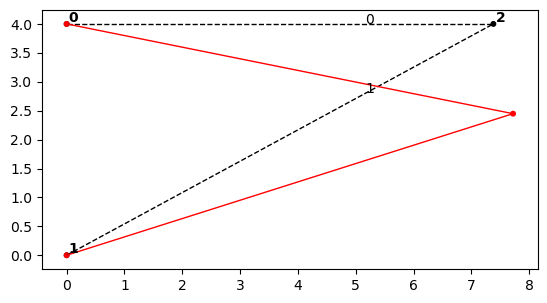

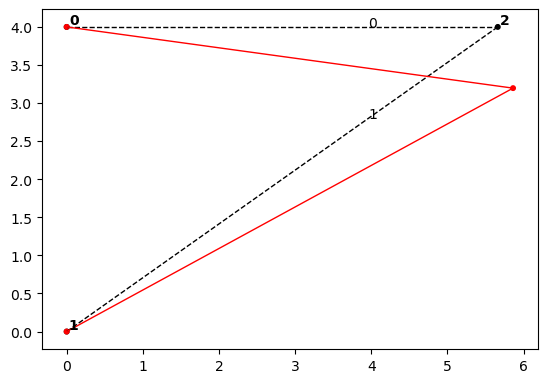

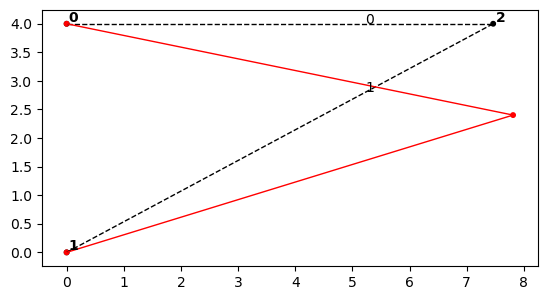

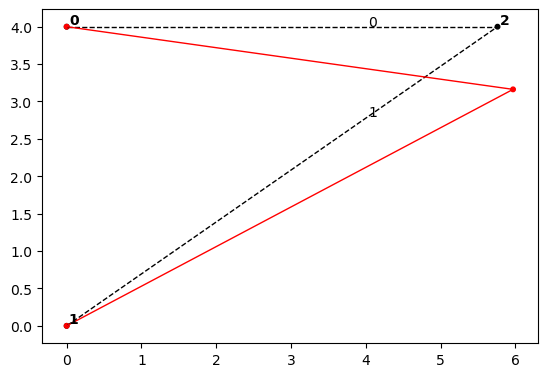

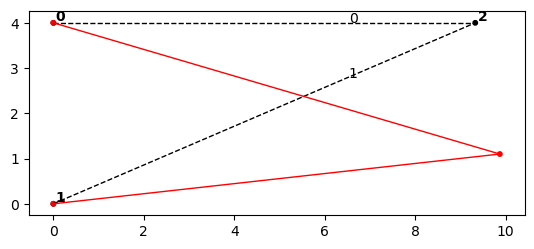

In [4]:
for i in structure_df.__iter__(5):
    #pprint.pprint(structure_df.get_K())
    Plotter.plot()